In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate, ZGate
from PIL import Image as im
import requests
import base64
import matplotlib.pyplot as plt
import numpy as np
import io

In [11]:
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    img = im.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
    plt.imshow(img)
    plt.axis('off') # allow to hide axis
    plt.savefig('image.png', dpi=1200)

In [12]:
def map_graph(edges, registry_size: int = 2, directed: bool = False):
    circ = QuantumCircuit((2 * registry_size) + 1, name='Graph Verify')
    def map_edge(from_node: int, to_node: int):
        target_qubit = (2 * registry_size)
        def add_x(number, start_qubit):
            exp = 1
            for qubit in range(start_qubit, start_qubit + registry_size):
                if not (number & exp):
                    circ.x(qubit)
                exp *= 2

        add_x(from_node, 0)
        add_x(to_node, registry_size)
        circ.append(XGate().control(registry_size * 2), list(range((2 * registry_size))) + [target_qubit])
        add_x(from_node, 0)
        add_x(to_node, registry_size)
    for e in edges:
        map_edge(e[0], e[1])
        circ.barrier()
        if not directed:
            map_edge(e[1], e[0])
            circ.barrier()
    return circ



In [ ]:
class MazeOracleGenerator:

    def __init__(self, total_nodes: int, max_path_length: int, directed_graph: bool = False):
        self.__node_bits_size = int(np.ceil( np.log2(total_nodes) ))
        self.__max_path_length = max_path_length
        self.__directed_graph = directed_graph
        self.__edges = []

    def add_edges(self, edges: list[tuple]) -> 'MazeOracleGenerator':
        self.__edges += edges
        return self

    def add_edge(self, edge: tuple[int]) -> 'MazeOracleGenerator':
        self.add_edges([edge])
        return self
    
    def __generate_edge_check_circuit(self):
        size = self.__node_bits_size

        circ = QuantumCircuit((2 * size) + 1, name='Edge Check')
        def map_edge(from_node: int, to_node: int):
            target_qubit = (2 * size)
            def add_x(number, start_qubit):
                exp = 1
                for qubit in range(start_qubit, start_qubit + size):
                    if not (number & exp):
                        circ.x(qubit)
                    exp *= 2

            add_x(from_node, 0)
            add_x(to_node, size)
            circ.append(XGate().control(size * 2), list(range((2 * size))) + [target_qubit])
            add_x(from_node, 0)
            add_x(to_node, size)

        for e in self.__edges:
            map_edge(e[0], e[1])
            circ.barrier()

            if not self.__directed_graph:
                map_edge(e[1], e[0])
                circ.barrier()

        return circ

    def generate(self):
        num_qubit_in_path = (self.__max_path_length + 1) * self.__node_bits_size
        total_size = num_qubit_in_path + self.__max_path_length

        # generate circuit for edge checking on whole graph
        full_edge_check = QuantumCircuit(total_size, name='Full Edge Check')
        edge_check = self.__generate_edge_check_circuit()
        for s in range(self.__max_path_length):
            start_qubit = s * self.__node_bits_size
            full_edge_check.append(edge_check, list(range(start_qubit, start_qubit + 2 * self.__node_bits_size)) + [num_qubit_in_path + s])
        
        circ = QuantumCircuit(total_size, name='Maze Oracle')
        circ.append(full_edge_check, range(total_size))                                                 # apply graph check
        circ.append(ZGate().control(self.__max_path_length - 1), range(num_qubit_in_path, total_size))  # flip correct combination
        circ.append(full_edge_check, range(total_size))                                                 # re-apply graph check (to reset ancillas)
        return circ


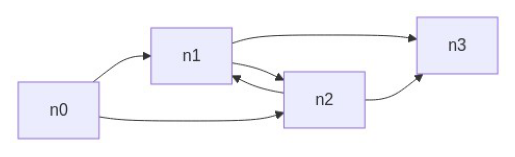

In [14]:
mm("""
flowchart LR;
   n0 --> n1 & n2
   n1 & n2 --> n3
   n1 --> n2
   n2 --> n1
""")

In [ ]:
edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3)
]
oracle = MazeOracleGenerator(4, max_path_length=4).add_edges(edges).generate()

In [17]:
circ = QuantumCircuit(8)
for i in range(6):
    circ.h(i)
circ.append(oracle, list(range(8)))

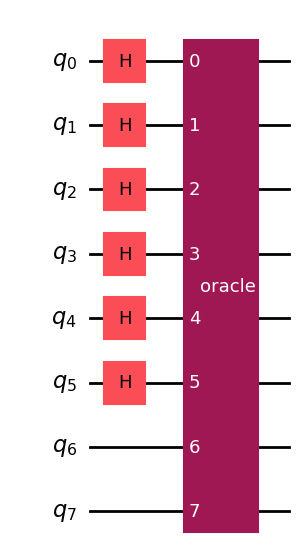

In [18]:
circ.draw('mpl')